In [7]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, UpSampling1D, Conv2DTranspose, MaxPool1D, Dropout, Conv1D, Conv2D, Conv3D, Flatten, MaxPool2D, AveragePooling2D, BatchNormalization

In [8]:
# plt.figure(1)

# plt.subplot(121)
# plt.imshow(im, cmap='gray')
# plt.title('Input')

# plt.subplot(122)
# plt.imshow(noise1, cmap='gray')
# plt.title('Noisy image SE {:.2f}'.format(error1))

# plt.show(block=False)

In [9]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1) # Encoder - 4
        self.conv5 = nn.Conv2d(128, 256, 3, 2, 1) # Encoder - 5
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv5_t = nn.Conv2d(256, 256, 3, 1, 1) # Decoder - 5
        self.conv4_t = nn.Conv2d(256, 128, 3, 1, 1) # Decoder - 4
        self.conv3_t = nn.Conv2d(128, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = self.bn16(F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.bn128(F.relu(self.conv4(out)))
        out = self.bn256(F.relu(self.conv5(out)))
        out = self.upsample(self.bn256(F.relu(self.conv5_t(out))))
        out = self.upsample(self.bn128(F.relu(self.conv4_t(out))))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.tanh(self.conv0_t(out))
        return out

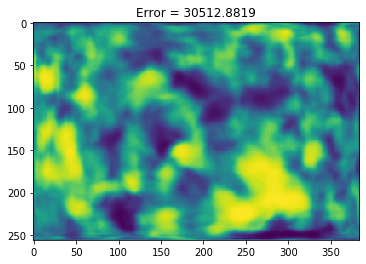

In [14]:
files = ['lena', 'saturn']
for file in files:
    im = imread('../data/denoising/{}.png'.format(file))
    noise = imread('../data/denoising/{}-noisy.png'.format(file))
    
    noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    net = EncDec()

    for itr in range(5):

        eta = torch.randn(*noisy_img.size())
        out = net(eta)
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()

        #plt.subplot(3, 2, (itr+1))
        plt.imshow(out_img)
        plt.title("Error = %.4f" % ((im - out_img)**2).sum())
        plt.savefig('../data/output/{}/output_{}.png'.format(file, itr+1))

In [15]:
MAX_EPOCHS = 500
files = ['lena', 'saturn']
for file in files:
    im = imread('../data/denoising/{}.png'.format(file))
    noise = imread('../data/denoising/{}-noisy.png'.format(file))
    noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    
    eta = torch.randn(*noisy_img.size())
    net = EncDec()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    training_error = np.zeros((MAX_EPOCHS))
    testing_error = np.zeros((MAX_EPOCHS))
    
    all_dumps = {}
    
    print ("------ {} ------".format(file))
    
    for itr in range(MAX_EPOCHS):
        out = net(eta)
        optimizer.zero_grad()
        loss = criterion(out, clean_img)
        loss.backward()
        optimizer.step()
        out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
        training_error[itr] = ((im - out_img)**2).sum()
        testing_error[itr] = ((im - net(noisy_img)[0, 0, :, :].transpose(0,1).detach().numpy())**2).sum()

        if itr % 50 == 0:
            print (training_error[itr], testing_error[itr])
    
    all_dumps['{}_train'.format(file)], all_dumps['{}_test'.format(file)] = training_error, testing_error
    

------ lena ------
36888.48383974952 29720.06695289116
993.9783250294734 6654.042638982422
612.1675398432127 7288.070395867264
499.9577546526658 7959.833847630793
678.231240733725 8963.517968270104
497.5786687104883 6567.762768237554
356.52594397969085 7314.067518334461
325.21214261304857 8480.078494553849
322.9478557260102 8747.339793438852
301.2011902519091 8582.48726080848
------ saturn ------
32000.55897449257 21308.18421236696
541.4610656248253 7711.21168838126
331.07460103208814 7672.424551484409
252.73191376949495 7172.874817374371
198.44867426675165 6879.894973873353
176.96962287975393 6962.42950625202
172.84625847975738 7264.328560842678
132.93941162362773 7202.148508853826
123.65275732594758 7346.595996309372
108.99002664583941 7604.865860752296


In [18]:
all_dumps['saturn_test']

array([21308.18421237, 20853.07090254, 17197.61722211, 11673.84685325,
        7050.70617117,  5782.19846802,  5452.27295204,  5383.8883432 ,
        7094.38089446,  8520.98548365,  8854.65465698,  8090.99745075,
        7040.94490039,  6365.54666476,  6118.73154855,  6262.96120201,
        6774.85814249,  7316.27647116,  7641.34249187,  7712.02900101,
        7500.06269936,  7225.89277866,  7169.01795816,  7190.08985215,
        7256.68996639,  7523.01501584,  7885.24740876,  8176.6935135 ,
        8264.79337591,  8078.27469945,  7819.05461435,  7680.08037898,
        7686.39864728,  7811.03727065,  7895.47201627,  7812.1692532 ,
        7611.35943603,  7388.29213896,  7249.17004538,  7222.57598035,
        7244.93774388,  7345.44266991,  7539.61761066,  7742.2563954 ,
        7855.58661156,  7813.03670865,  7681.37532337,  7595.97465036,
        7615.41635104,  7691.601085  ,  7711.21168838,  7636.88693897,
        7524.8576222 ,  7440.96096725,  7407.13222567,  7399.31191516,
      

In [ ]:

# noise1 = imread('../data/denoising/lena-noisy.png')
# #error1 = ((im - noise1)**2).sum()
# #print ('Noisy image SE: {:.2f}'.format(error1))


# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr=0.01)
# eta = torch.randn(*noisy_img.size())
# training_error = np.zeros((MAX_EPOCHS))

# for itr in range(MAX_EPOCHS):
#     out = net(eta)
#     optimizer.zero_grad()
#     loss = criterion(out, clean_img)
#     loss.backward()
#     optimizer.step()
#     out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
#     training_error[itr] = ((im - out_img)**2).sum()
    
#     if itr % 50 == 0:
#         print (training_error[itr])
    

In [ ]:
# training_error[0] = 6

In [ ]:
# training_error